# **Customer Churn Prediction for a multinational bank**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## loading the data

kaggle dataset link: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/data

In [4]:
df = pd.read_csv('../data/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


churn column is used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

## Exploratory Data Analysis

In [5]:
print(df.info())

# Check for missing values
print(df.isnull().sum())
#no null values are found.

df.duplicated().sum()
#no duplicated rows either

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None
customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_nu

0

No missing values or duplicated rows found

In [6]:
# distribution of churn and non churn data
churn_counts = df['churn'].value_counts()
print(churn_counts)

churn
0    7963
1    2037
Name: count, dtype: int64


The dataset is thus imbalanced.

### Exploring Numerical Feature distributions

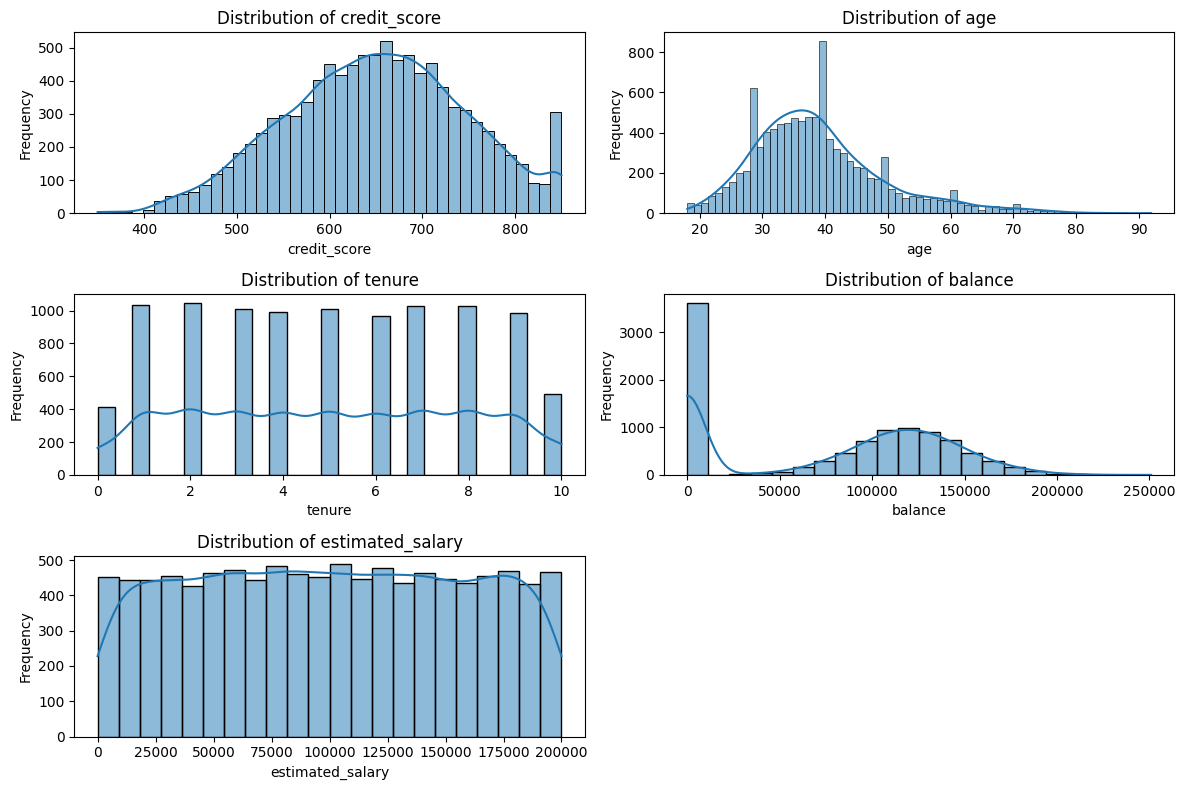

In [7]:
# distribution of numerical features.

numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

n_features = len(numerical_features)
n_cols = 2  # Number of columns
n_rows = (n_features + n_cols - 1) // n_cols

# Creating subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten to easily iterate

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any extra axes if n_features < n_cols * n_rows
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
#  summmary statistics for numerical data
print(df.describe())

        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.4

**Key findings**

Mean credit score - 650.52 <br>
mean age - 38 <br>
mean estimated salary - 10,0090.23 <br>
mean tenure of a customer in years - 5 years

In [9]:
df['products_number'].value_counts()

products_number
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

most customers have subscribed to one or 2 products.

#### Exploring Relationships between numerical features and churn

Exploring relationships between numerical features and churn


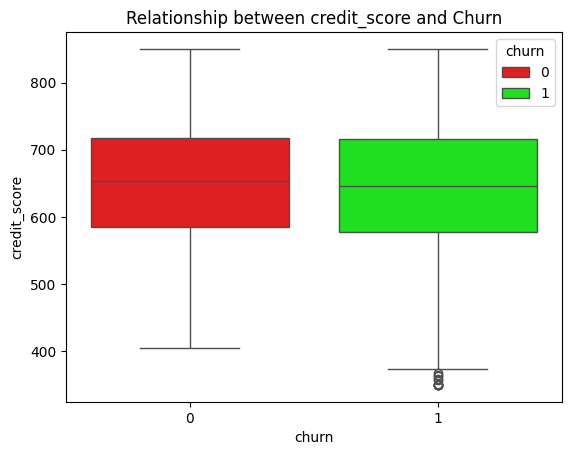

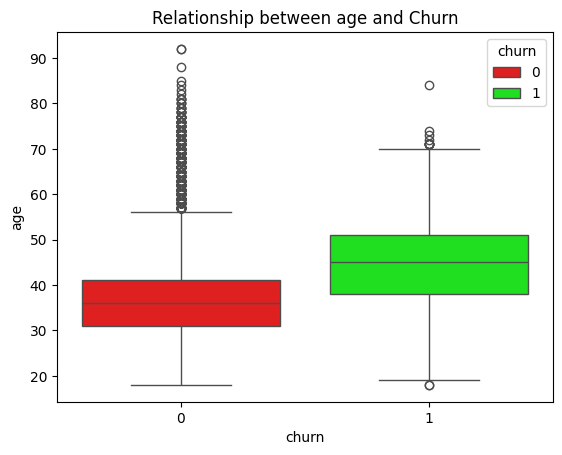

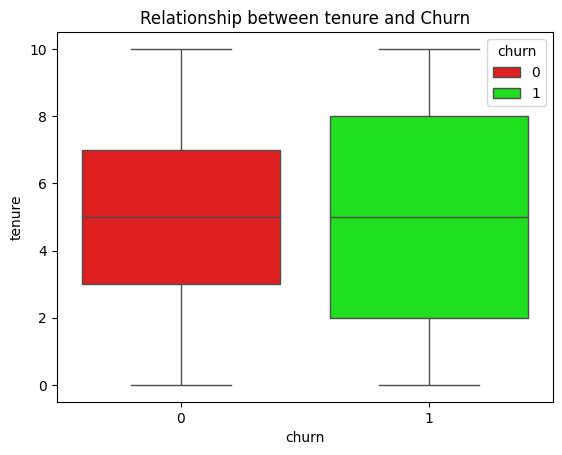

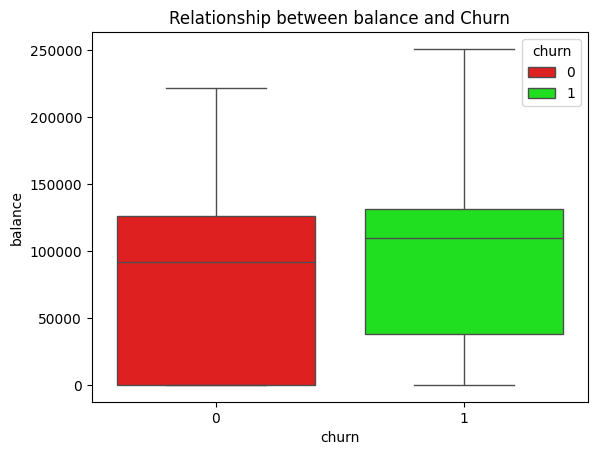

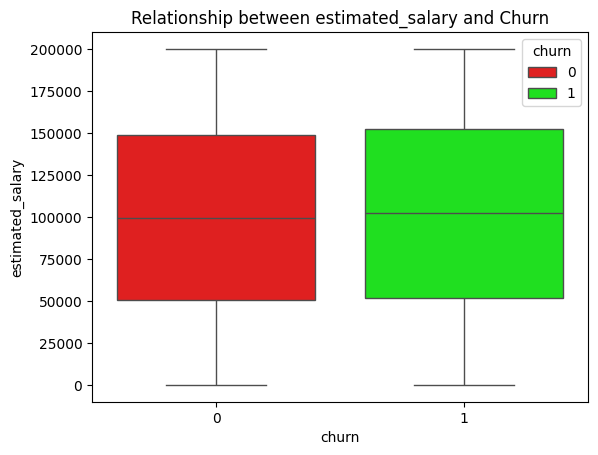

In [10]:
print('Exploring relationships between numerical features and churn')

custom_palette = {'lime', 'red'}
# Explore relationships between numerical features and churn
for col in numerical_features:
    plt.figure()
    sns.boxplot(x='churn', y=col, data=df,hue='churn', palette=custom_palette)
    plt.title(f'Relationship between {col} and Churn')
    plt.show()

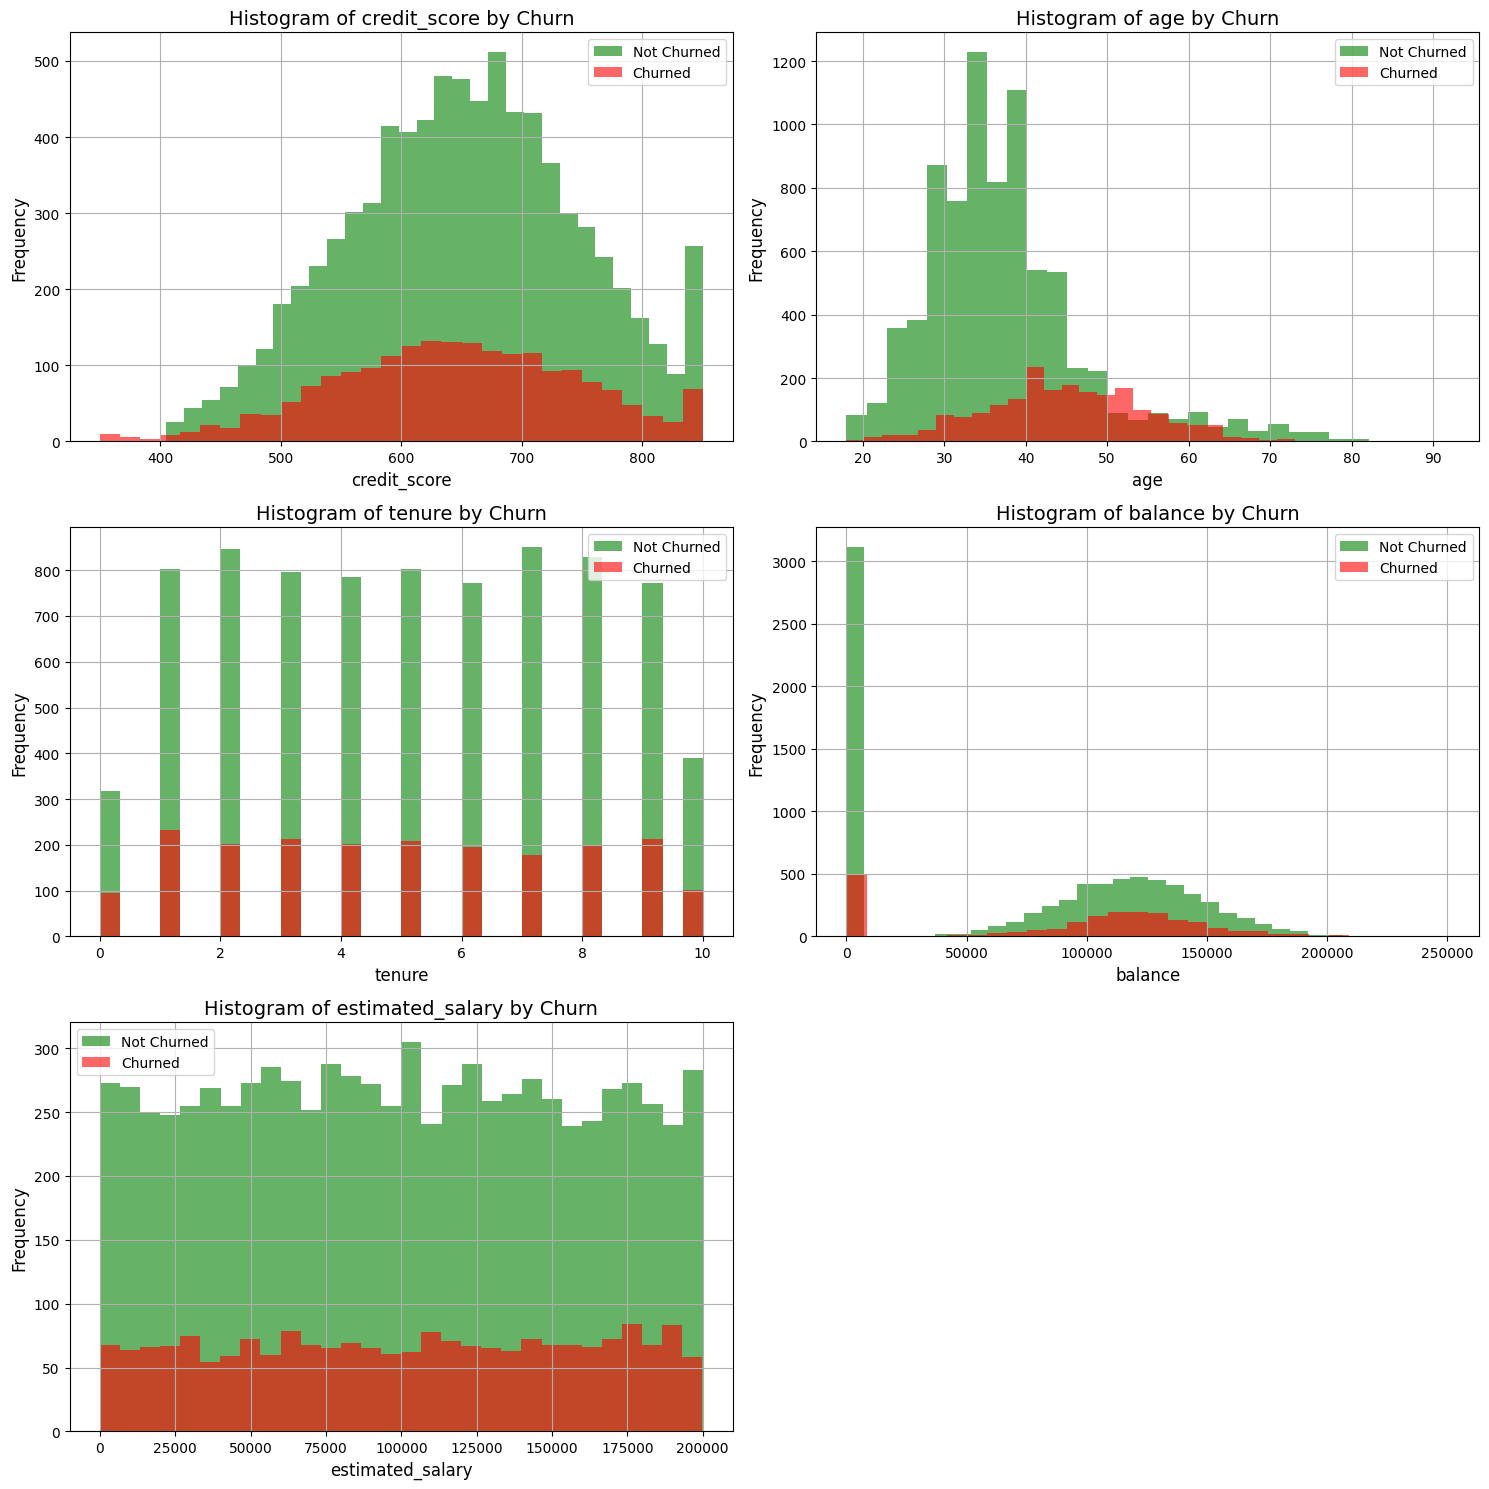

In [11]:
num_features = len(numerical_features)


cols = 2
# Calculating the number of rows required, using ceiling division
rows = (num_features + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()


for i, col in enumerate(numerical_features):
    ax = axes[i]  # Get the current axis
    df[df['churn'] == 0][col].hist(ax=ax, alpha=0.6, label='Not Churned', bins=30, color='green')
    df[df['churn'] == 1][col].hist(ax=ax, alpha=0.6, label='Churned', bins=30, color='red')
    ax.set_title(f'Histogram of {col} by Churn', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()

# Remove empty subplots if len(numerical_features) < rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

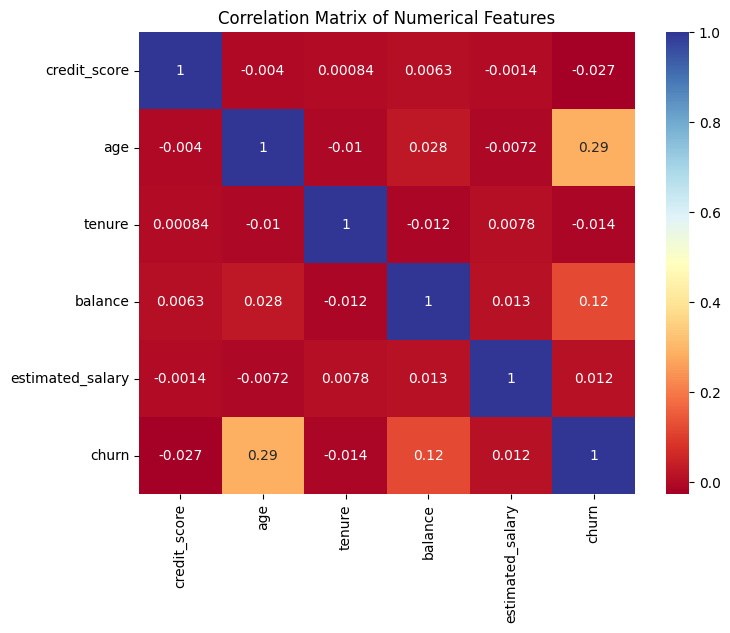

In [12]:
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary','churn']
# Explore correlations between numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='RdYlBu')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

we can thus say there's little to no multicollinearity between numerical variables.

### Exploring Categorical features

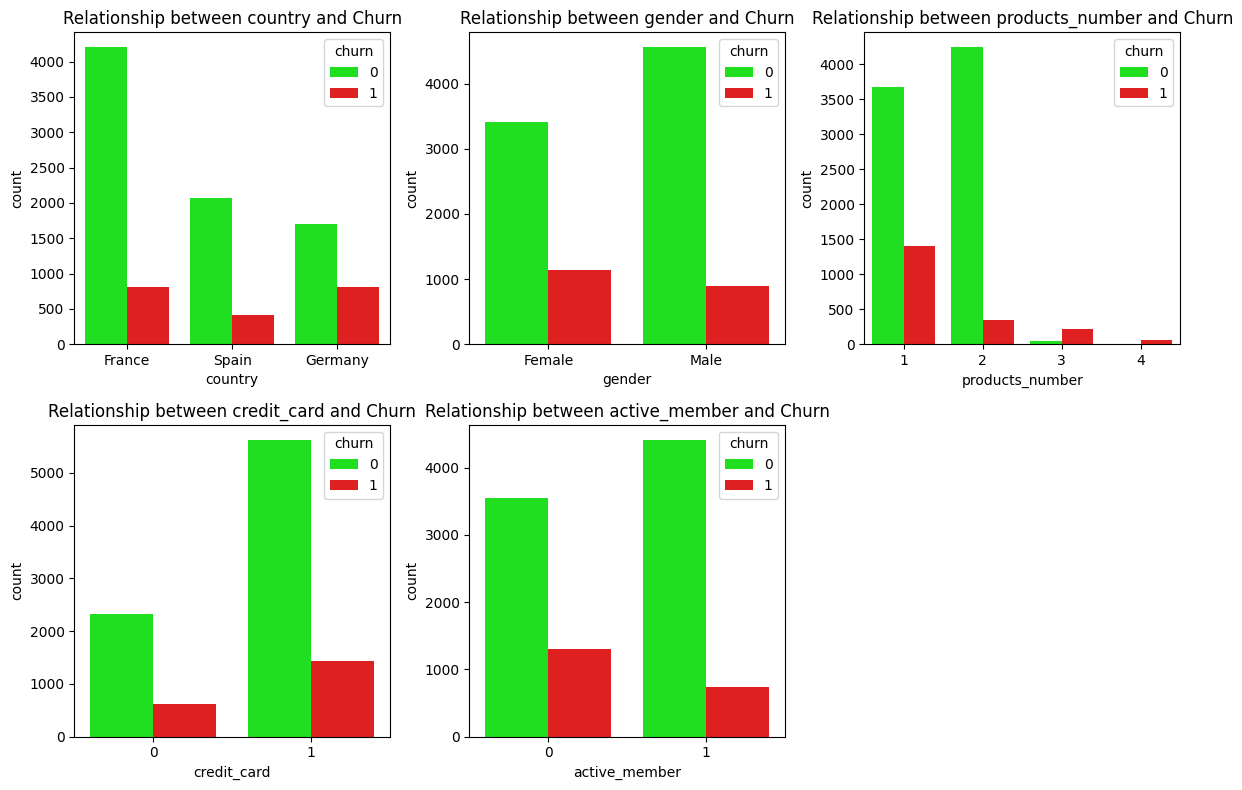

In [13]:
# Explore categorical features and their distribution

categorical_features = ['country', 'gender', 'products_number', 'credit_card', 'active_member']

custom_colors = ['lime', 'red']
num_cols = 3
num_rows = -(-len(categorical_features) // num_cols)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each categorical feature
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='churn', palette=custom_colors, data=df, ax=axes[i])
    axes[i].set_title(f'Relationship between {col} and Churn')

# Hide any unused axes
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Preprocessing

In [14]:
#dropping the customer id column
df= df.drop('customer_id', axis=1)
df.head(3)

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### Feature Engineering

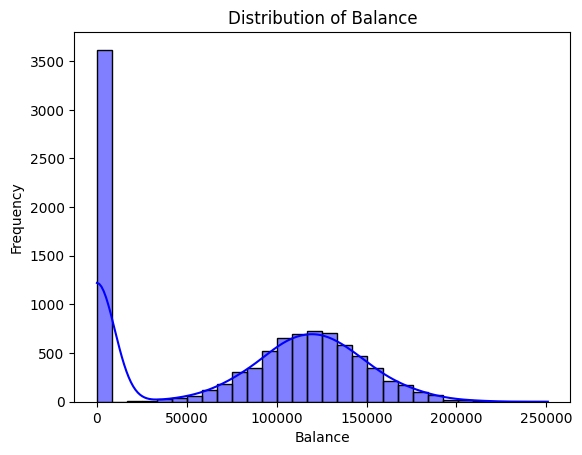

churn
0    3117
1     500
Name: count, dtype: int64

In [15]:
sns.histplot(data=df, x='balance', kde=True, bins=30, color='blue')

# Customize the plot
plt.title('Distribution of Balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()
df.loc[(df['balance']==0), 'churn' ].value_counts()

So we can say that a significant number of customers who have a zero balance have a propensity towards churning. Thus we can create another column to denote whether customers have zero balance or not.

In [16]:
# creating a new column based on bank balance
df['zero_balance'] = np.where(df['balance']>0, 0, 1)

### **Encoding categorical variables**

doing one hot encoding here.

In [17]:
df['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [18]:
df_encoded = pd.get_dummies(df, columns=['country', 'gender'], drop_first=True)
df_encoded.head()
#drop_first avoids multicollinearity by creating n-1 columns. this is cuz some algorithms that use linear models such as linreg,
#  logistic regression is affected by it

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,zero_balance,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,0,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,1,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,False,True,False


In [19]:
# Tree based Models like decision trees, random forests, or gradient boosting are not affected by multicollinearity. 
# These models can use all n dummy variables without any issues! Even deeplearning models are not affected by multicollinearity.

df_Encoded = pd.get_dummies(df, columns=['country', 'gender'])
df_Encoded.head()
#created another encoding above for better model interpretability without reducing feature space.

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,zero_balance,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,0,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,1,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0,False,False,True,True,False


But we can easily run any kind of model both linear and non linear in a dataset where there's no multicolinearity concerns. Also, we know that multicollinearity is not an issue here fom our correlation heatmap. so the first dataset is adequete for most of our models

In [20]:
print(df_encoded.dtypes)

credit_score          int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
zero_balance          int32
country_Germany        bool
country_Spain          bool
gender_Male            bool
dtype: object


The newly added encoded columns have been added as booleans. For consistency, converting them to numerical.
most libraries will automatically interpret booleans as 0 and 1 but to avoid any unexpected inconsistencies, conversion is done here

In [21]:
# converting boolean columns to integers
df_encoded[['country_Germany', 'country_Spain', 'gender_Male']] = df_encoded[['country_Germany', 'country_Spain', 'gender_Male']].astype(int)

# Checking the changes
df_encoded.head(3)


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,zero_balance,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0


In [22]:
# we will not be using this dataset for training models but we can use this to see correlation of churn against all variables
df_encoded_2 = df_Encoded.copy()
df_encoded_2[['country_France','country_Germany','country_Spain','gender_Female','gender_Male']] = df_encoded_2[['country_France','country_Germany','country_Spain','gender_Female','gender_Male']].astype(int)

# Checking the changes
df_encoded_2.head(3)


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,zero_balance,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0,1,0


Creating a dataset without the target column and plotting it against the target variable for correlation analysis of each variable

<Axes: title={'center': 'Correlation with Churn'}>

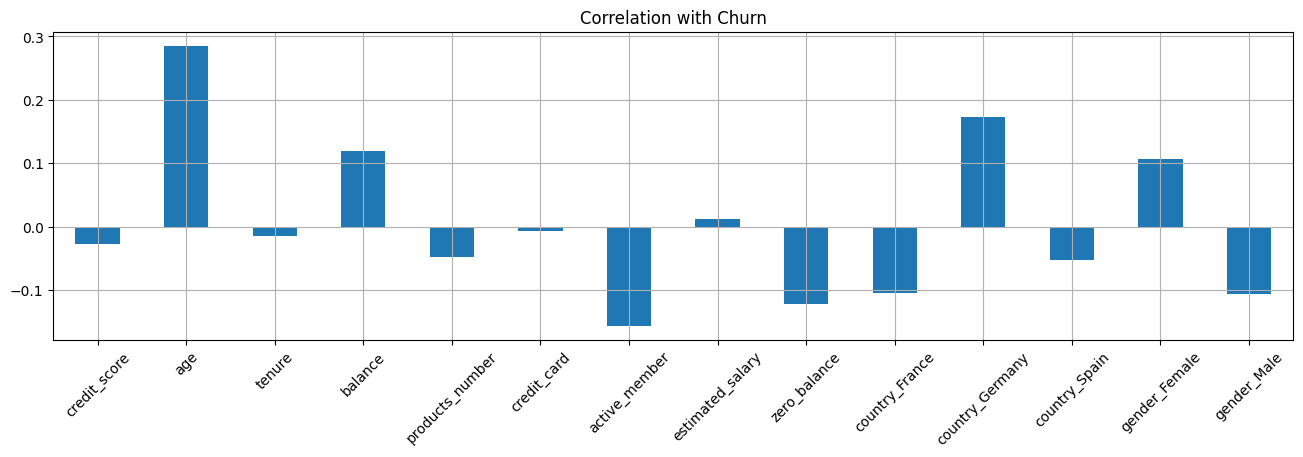

In [23]:
#seeing correlation between churn and all the other variables
data_without_target = df_encoded_2.drop('churn', axis=1)

data_without_target.corrwith(df_encoded_2['churn']).plot.bar(
    figsize=(16, 4), title="Correlation with Churn", fontsize=10, rot=45, grid=True
)

variables such as age and being from germany are more correlated with churning. While activeness of the member is negatively correlated. meaning, More active member have a lower possibility of dropping out from the banking service if we only consider activeness as a factor for determining churn.

### Train-test split and scaling

In [24]:
# this will be the dataset we will use for models
df_encoded.head()


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,zero_balance,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,0


In [25]:
X = df_encoded.drop(['churn'], axis=1)
y = df_encoded['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #70:30 split

stratify=y, it ensures that:

    The proportion of each class in the training set matches its proportion in the original dataset.
    The proportion of each class in the test set also matches its proportion in the original dataset.

In [26]:
# how the testing datset look after splitting
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df.head(3)

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,zero_balance,country_Germany,country_Spain,gender_Male
6417,790,37,6,0.00,2,1,1,119484.01,1,0,1,1
199,521,35,6,96423.84,1,1,0,10488.44,0,0,0,1
2051,712,37,1,106881.50,2,0,0,169386.81,0,0,0,0


#### Scaling the data

In [27]:
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

One-hot encoded features are already binary (0 or 1). Scaling them using StandardScaler will transform them to have a mean of 0 and a standard deviation of 1. So scaling the entire dataset together is ok here

In [28]:
# training data after scaling, it's considered the best practice to scale after splitting to avoid data leakage.
X_train_scaled

array([[-0.57558225, -1.79667873, -0.34947397, ..., -0.57823004,
        -0.57888987,  0.90036493],
       [ 0.39818245,  2.26982524, -1.38692851, ..., -0.57823004,
         1.72744428, -1.11066076],
       [ 1.69308232, -0.75641027, -1.38692851, ..., -0.57823004,
        -0.57888987,  0.90036493],
       ...,
       [ 0.17028007, -0.18899111,  1.37961693, ..., -0.57823004,
        -0.57888987, -1.11066076],
       [ 0.37746405, -0.37813083,  1.03379875, ..., -0.57823004,
         1.72744428,  0.90036493],
       [ 1.56877193,  1.13498693,  0.68798057, ..., -0.57823004,
         1.72744428,  0.90036493]])

In [29]:
# how our y train split looks like
y_train

9136    0
6410    0
2607    0
3201    0
3330    0
       ..
1467    0
4644    0
8942    0
2935    0
6206    0
Name: churn, Length: 7000, dtype: int64

### Addressing class imbalance

<Axes: xlabel='churn', ylabel='count'>

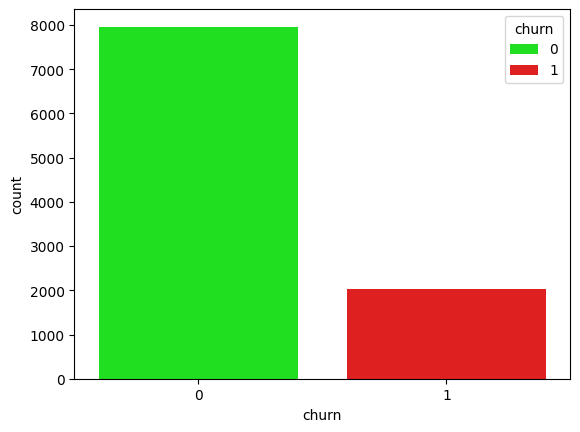

In [30]:
sns.countplot(x='churn', data=df_encoded, palette=custom_colors, hue='churn')

Two ways to address this imbalace are
1. using class weights balanced during model training and handling the imbalance that way
> That way, The algorithm gives higher weight to the minority class during optimization, ensuring it doesn’t favor the majority class disproportionately.
2. using resampling methodologies

we'll also be evaluating with metrics like recall and F1-score to avoid when the majority class training might give an incorrect representation of model performance with metrics like accuracy.

#####  Oversampling techniques instead of class weights - SMOTE

Oversampling instead of training weights in the model to address class imbalance to see if we can increase performance

In [31]:
#Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#scaling the resampled data
X_resampled= scaler.fit_transform(X_resampled)

Scaling is done seperately for resampled data to avoid data leakage. Instead of using the same scaling for test data, we have thus seperated the test data scaling from the resampled data scaling

In [32]:
# new distribution of data, churn and non churn data classes are now equal

print(f'value distribution before resampling:',pd.Series(y_train).value_counts())
print(f'value distributionn after resampling:',pd.Series(y_resampled).value_counts())

value distribution before resampling: churn
0    5574
1    1426
Name: count, dtype: int64
value distributionn after resampling: churn
0    5574
1    5574
Name: count, dtype: int64


## Model selection

In [33]:
#creating a dataframe to store model performances
results = pd.DataFrame(columns=['Model','Accuracy', 'F1_Score','Precision', 'Recall'])

### 1. Logistic Regression

#### Without oversampling

In [34]:
logreg_model = LogisticRegression(class_weight='balanced', random_state=42)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [35]:
#predicting using test data
y_pred= logreg_model.predict(X_test_scaled)
#for train data
y_train_pred = logreg_model.predict(X_train_scaled)

In [36]:
#training accuracy
accuracy_train = accuracy_score( y_train, y_train_pred)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      2389
           1       0.40      0.73      0.51       611

    accuracy                           0.72      3000
   macro avg       0.65      0.72      0.66      3000
weighted avg       0.81      0.72      0.74      3000

[[1711  678]
 [ 167  444]]


In [37]:
logreg_results = pd.DataFrame([['Logistic Regression without oversampling',accuracy, f1,precision,recall]], columns=['Model','Accuracy', 'F1_Score','Precision', 'Recall'])
# concatenating the results of logistic regression to the results dataframe
results=pd.concat([results, logreg_results], ignore_index=True)
results

C:\Users\subha\AppData\Local\Temp\ipykernel_20680\429763459.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results=pd.concat([results, logreg_results], ignore_index=True)


,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678


#### With Oversampling

In [38]:
logreg_model = LogisticRegression( random_state=42)
logreg_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

In [39]:
#predicting using test data
y_pred= logreg_model.predict(X_test_scaled)
#for train data
y_train_pred = logreg_model.predict(X_resampled)

In [40]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Training Accuracy 0.7697344815213492
              precision    recall  f1-score   support

           0       0.91      0.58      0.71      2389
           1       0.32      0.78      0.46       611

    accuracy                           0.62      3000
   macro avg       0.62      0.68      0.59      3000
weighted avg       0.79      0.62      0.66      3000

[[1394  995]
 [ 133  478]]


In [41]:
logreg_results = pd.DataFrame([['Logistic Regression with oversampling',accuracy, f1,precision,recall]], columns=['Model','Accuracy', 'F1_Score','Precision', 'Recall'])
# concatenating the results of logistic regression to the results dataframe
results=pd.concat([results, logreg_results], ignore_index=True)

In [42]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324


### 2. Random Forest Classifier

#### Without Oversampling

In [43]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
y_pred = rf_model.predict(X_test_scaled)
#for training dataset
y_train_pred = rf_model.predict(X_train_scaled)

In [45]:
#training accuracy
accuracy_train = accuracy_score( y_train, y_train_pred)
print('training accuracy:', accuracy_train)

#model evaluation with random forest classifier.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

training accuracy: 0.9998571428571429
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2389
           1       0.75      0.45      0.57       611

    accuracy                           0.86      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.85      0.86      0.84      3000

[[2298   91]
 [ 334  277]]


In [46]:
results_rf = pd.DataFrame([['Random Forest without oversampling',accuracy, f1,precision,recall]], columns=['Model','Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_rf], ignore_index=True)

In [47]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355


#### Random Forest with Oversampling

In [48]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [49]:
X_test_scaled

array([[ 1.44446154, -0.18899111,  0.34216239, ..., -0.57823004,
         1.72744428,  0.90036493],
       [-1.34216297, -0.37813083,  0.34216239, ..., -0.57823004,
        -0.57888987,  0.90036493],
       [ 0.63644403, -0.18899111, -1.38692851, ..., -0.57823004,
        -0.57888987, -1.11066076],
       ...,
       [-1.54934695,  0.09471847, -0.00365579, ...,  1.72941551,
        -0.57888987,  0.90036493],
       [ 1.46517994, -0.94554999, -0.34947397, ...,  1.72941551,
        -0.57888987, -1.11066076],
       [-0.26480628, -1.60753901,  1.37961693, ..., -0.57823004,
        -0.57888987,  0.90036493]])

In [50]:
#predicting using test data
y_pred= rf_model.predict(X_test_scaled)
#for train data
y_train_pred = rf_model.predict(X_resampled)

In [51]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy:',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Training Accuracy: 1.0
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2389
           1       0.50      0.67      0.58       611

    accuracy                           0.80      3000
   macro avg       0.70      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000

[[1979  410]
 [ 199  412]]


In [52]:
# creating a temp dataframe and appending the evaluation into the results df
results_rf_oversampled = pd.DataFrame([['Random Forest with oversampling', accuracy, f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_rf_oversampled], ignore_index=True)
results_rf = pd.concat([results_rf, results_rf_oversampled], ignore_index=True)

In [53]:
#results = results.drop([3,4], axis=0)
#results= results[0:0] #clearing all rows with this

In [54]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304


### 3. Support Vector Machine

#### Without Oversampling

In [55]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [56]:
y_pred = svm_model.predict(X_test_scaled)
#for training dataset
y_train_pred = svm_model.predict(X_train_scaled)

In [57]:
#training accuracy
accuracy_train = accuracy_score( y_train, y_train_pred)
print('training accuracy:', accuracy_train)

#model evaluation with random forest classifier.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

training accuracy: 0.7962857142857143
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000

[[2389    0]
 [ 611    0]]


c:\Users\subha\Documents\NSBM\y3s2\Machine learning\final project\mlprojectenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\subha\Documents\NSBM\y3s2\Machine learning\final project\mlprojectenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\subha\Documents\NSBM\y3s2\Machine learning\final project\mlprojectenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [58]:
# creating a temp dataframe and appending the evaluation into the results df
results_svm = pd.DataFrame([['SVM without oversampling ',accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_svm], ignore_index=True)

In [59]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
4,SVM without oversampling,0.796333,0.000000,0.000000,0.000000


#### SVM with oversampling

In [60]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_resampled, y_resampled)

SVC(kernel='linear', random_state=42)

In [61]:
#predicting using test data
y_pred= svm_model.predict(X_test_scaled)
#for train data
y_train_pred = svm_model.predict(X_resampled)

In [62]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy:',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.7680301399354145
              precision    recall  f1-score   support

           0       0.91      0.59      0.72      2389
           1       0.33      0.78      0.46       611

    accuracy                           0.63      3000
   macro avg       0.62      0.69      0.59      3000
weighted avg       0.79      0.63      0.67      3000

[[1418  971]
 [ 135  476]]


In [63]:
# creating a temp dataframe and appending the evaluation into the results df
results_svm = pd.DataFrame([['SVM with oversampling', accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_svm], ignore_index=True)

In [64]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
4,SVM without oversampling,0.796333,0.000000,0.000000,0.000000
5,SVM with oversampling,0.631333,0.462585,0.328956,0.779051


### 4. Gradient Boosting Classifier (XGB)



#### Without oversampling

In [65]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
y_pred = xgb_model.predict(X_test_scaled)

#for training dataset
y_train_pred = xgb_model.predict(X_train_scaled)

In [67]:
#training accuracy
accuracy_train = accuracy_score( y_train, y_train_pred)
print('training accuracy:', accuracy_train)

#model evaluation with random forest classifier.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

training accuracy: 0.9628571428571429
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2389
           1       0.72      0.51      0.60       611

    accuracy                           0.86      3000
   macro avg       0.80      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000

[[2265  124]
 [ 299  312]]


In [68]:
# creating a temp dataframe and appending the evaluation into the results df
results_xgb = pd.DataFrame([['XGB without oversampling', accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_xgb], ignore_index=True)

In [69]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
4,SVM without oversampling,0.796333,0.000000,0.000000,0.000000
5,SVM with oversampling,0.631333,0.462585,0.328956,0.779051
6,XGB without oversampling,0.859000,0.595989,0.715596,0.510638


#### With Oversampling

In [70]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [71]:
#predicting using test data
y_pred= xgb_model.predict(X_test_scaled)
#for train data
y_train_pred = xgb_model.predict(X_resampled)

In [72]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy:',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9601722282023681
              precision    recall  f1-score   support

           0       0.90      0.16      0.27      2389
           1       0.22      0.93      0.36       611

    accuracy                           0.32      3000
   macro avg       0.56      0.54      0.31      3000
weighted avg       0.76      0.32      0.29      3000

[[ 377 2012]
 [  42  569]]


In [73]:
# creating a temp dataframe and appending the evaluation into the results df
results_xgb_oversampled = pd.DataFrame([['XGB with oversampling', accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results = pd.concat([results, results_xgb_oversampled], ignore_index=True)
results_xgb = pd.concat([results_xgb, results_xgb_oversampled], ignore_index=True)

In [74]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
4,SVM without oversampling,0.796333,0.000000,0.000000,0.000000
5,SVM with oversampling,0.631333,0.462585,0.328956,0.779051
6,XGB without oversampling,0.859000,0.595989,0.715596,0.510638
7,XGB with oversampling,0.315333,0.356516,0.220457,0.931260


---
---
---

Based on the 4 models tested on the training set, **random forest with oversampling**
performs better than all the other models if we consider more than just the accuracy.


We are selecting the model with resampled data and doing hyperparameter tuning to further increase model fit and performance





## Hyperparameter Tuning for Random Forest

In [75]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [76]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=2, scoring='accuracy',verbose=2)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [77]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.8630006269716827
Test accuracy: 0.8673333333333333


In [78]:
#model evaluation with random forest with hyperparameter tunining.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.81      0.46      0.58       611

    accuracy                           0.87      3000
   macro avg       0.84      0.71      0.75      3000
weighted avg       0.86      0.87      0.85      3000

[[2323   66]
 [ 332  279]]


In [79]:
# creating a temp dataframe and appending the evaluation into the results df and result_rf
results_rf_tuned = pd.DataFrame([['Random Forest without oversampling tuned',accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results_rf = pd.concat([results_rf, results_rf_tuned], ignore_index=True)

In [80]:
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)

             Feature  Importance
1                age    0.298386
4    products_number    0.219158
3            balance    0.096870
0       credit_score    0.085475
7   estimated_salary    0.084233
6      active_member    0.067958
9    country_Germany    0.047635
2             tenure    0.045136
8       zero_balance    0.017568
11       gender_Male    0.017511
5        credit_card    0.010506
10     country_Spain    0.009564


#### Tuning parameters with oversampling

In [81]:
grid_search_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=2, scoring='accuracy',verbose=2)

# Fit the grid search
grid_search_2.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [82]:
# Best parameters and best score
print("Best parameters:", grid_search_2.best_params_)
print("Best cross-validation score:", grid_search_2.best_score_)

# Evaluate the best model on the test set
best_rf_model_2 = grid_search_2.best_estimator_
y_pred = best_rf_model_2.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.8380875493362039
Test accuracy: 0.7953333333333333


In [83]:
#model evaluation with random forest oversampled with hyperparameter tunining.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.87      2389
           1       0.50      0.68      0.58       611

    accuracy                           0.80      3000
   macro avg       0.70      0.75      0.72      3000
weighted avg       0.83      0.80      0.81      3000

[[1968  421]
 [ 193  418]]


In [84]:
# creating a temp dataframe and appending the evaluation into the results df and result_rf
results_rf_oversampled_tuned = pd.DataFrame([['Random Forest with oversampling tuned',accuracy, f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results_rf = pd.concat([results_rf, results_rf_oversampled_tuned], ignore_index=True)

In [85]:
results_rf

,Model,Accuracy,F1_Score,Precision,Recall
0,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
1,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
2,Random Forest without oversampling tuned,0.867333,0.583682,0.808696,0.456628
3,Random Forest with oversampling tuned,0.795333,0.576552,0.498212,0.684124


## Final Model selection

Random Forest Shows less volatility compared to XGB and performed well on both tests with oversampling and without oversampling.
It's performance is at an even level with an f1 score of .57 with oversampling.

In [86]:
results

,Model,Accuracy,F1_Score,Precision,Recall
0,Logistic Regression without oversampling,0.718333,0.512406,0.395722,0.726678
1,Logistic Regression with oversampling,0.624000,0.458733,0.324508,0.782324
2,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
3,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
4,SVM without oversampling,0.796333,0.000000,0.000000,0.000000
5,SVM with oversampling,0.631333,0.462585,0.328956,0.779051
6,XGB without oversampling,0.859000,0.595989,0.715596,0.510638
7,XGB with oversampling,0.315333,0.356516,0.220457,0.931260


In [87]:
results_rf

,Model,Accuracy,F1_Score,Precision,Recall
0,Random Forest without oversampling,0.858333,0.565884,0.752717,0.453355
1,Random Forest with oversampling,0.797000,0.575017,0.501217,0.674304
2,Random Forest without oversampling tuned,0.867333,0.583682,0.808696,0.456628
3,Random Forest with oversampling tuned,0.795333,0.576552,0.498212,0.684124


**Reasons for current performance constraints**

Churning is not completely predictable and we've seen that there is not a single variable that has a correlation against churning with a value over 0.5. So it's safe to assume that correlation cannot just be captured by the features in the dataset and there's many other variables that impact on customer churn. Yet, our model can distinguish between churning and non churning customers with over 86% of accuracy.

Oversampling with SMOTE, working with model weights, optimizing hyperparameters and preprocessing has contributed towards teaching this performance.

### Getting predictions by inputing new data to the model

In [88]:
input_data =  np.array([[6417, 790, 37, 6, 0.00, 2, 1, 119484.01, 1, 0, 1, 1]])
input_data =scaler.transform(input_data)

c:\Users\subha\Documents\NSBM\y3s2\Machine learning\final project\mlprojectenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [89]:
predictions = best_rf_model_2.predict(input_data)
probabilities = best_rf_model_2.predict_proba(input_data)
print("Predictions:", predictions)
print("Probabilities:", probabilities)

Predictions: [0]
Probabilities: [[0.71982456 0.28017544]]


This means that the model finds it 71% probable that the customer will not churn and will stay with the bank

## Model Deployment

we are using fast API to serve our model to an API endpoint. and uvicorn as the ASGI. pickle is used to save and load the trained ml  model.
Pydantic for data validation. 

In [90]:
#creating a pickle file using serialization
import pickle
pickle_out = open("../churn_predictor.pkl",'wb')
pickle.dump(best_rf_model_2, pickle_out)
pickle_out.close()

In [91]:
#serializing the scaler
with open('../scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

here we serialize the trained model so that we can load it later for prediction without retraining the model.

## Further optimization tests with different scaling configurations using XGB

Applying the same scaling for the test data that's been applied to the resampled data and seeing if there's a difference in model performance.

### Trying it out with XGB

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)

# The difference done here is we are scaling the data with the same scaling applied to the resampled data.
X_test_scaled = scaler.transform(X_test)


In [232]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train_balanced)

#predicting using test data
y_pred= xgb_model.predict(X_test_scaled)
#for train data
y_train_pred = xgb_model.predict(X_train_scaled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:43:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [233]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy:',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9601722282023681
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      2389
           1       0.52      0.64      0.57       611

    accuracy                           0.81      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.81      0.81      3000

[[2032  357]
 [ 222  389]]


In [234]:
results_xgb_scaled_diff= pd.DataFrame([['XGB with oversampling, diff scaling',accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results_xgb = pd.concat([results_xgb, results_xgb_scaled_diff], ignore_index=True)

In [235]:
results_xgb

,Model,Accuracy,F1_Score,Precision,Recall
0,XGB without oversampling,0.859000,0.595989,0.715596,0.510638
1,XGB with oversampling,0.315333,0.356516,0.220457,0.931260
2,XGB with oversampling,0.315333,0.356516,0.220457,0.931260
3,"XGB with oversampling, diff scaling",0.807000,0.573324,0.521448,0.636661


#### Tuning hyperparams
doing some hyperparameter tuning with randomsearchcv

In [245]:

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# parameter grid for xgb
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


random_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=100,  # Number of random combinations
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)



In [246]:
random_xgb.fit(X_train_scaled, y_train_balanced)

# Print the best parameters and best cross-validation score
print("\nXGBoost Best Parameters (RandomizedSearchCV):", random_xgb.best_params_)
print("XGBoost Best Cross-Validation Score: {:.2f}".format(random_xgb.best_score_))

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Best Parameters (RandomizedSearchCV): {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
XGBoost Best Cross-Validation Score: 0.85
Test accuracy: 0.862
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2389
           1       0.84      0.40      0.54       611

    accuracy                           0.86      3000
   macro avg       0.85      0.69      0.73      3000
weighted avg       0.86      0.86      0.84      3000



In [247]:
#training accuracy
accuracy_train = accuracy_score( y_resampled, y_train_pred)
print('Training Accuracy:',accuracy_train)

#model evaluation with logistic reg.
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9601722282023681
[[2343   46]
 [ 368  243]]


In [248]:
results_xgb_scaled_diff_tuned= pd.DataFrame([['XGB with oversampling, diff scaling, Tuned',accuracy,f1,precision,recall]], columns=['Model', 'Accuracy', 'F1_Score','Precision', 'Recall'])
results_xgb = pd.concat([results_xgb, results_xgb_scaled_diff_tuned], ignore_index=True)

In [250]:
#results_xgb = results_xgb.drop([2, 5], axis=0)
#results_xgb = results_xgb.reset_index(drop=True)

In [252]:
print('results from all xgboost models')
results_xgb

results from all xgboost models


,Model,Accuracy,F1_Score,Precision,Recall
0,XGB without oversampling,0.859000,0.595989,0.715596,0.510638
1,XGB with oversampling,0.315333,0.356516,0.220457,0.931260
2,"XGB with oversampling, diff scaling",0.807000,0.573324,0.521448,0.636661
3,"XGB with oversampling, diff scaling, Tuned",0.862000,0.540000,0.840830,0.397709


Thus there's an impact of scaling on the results of the xgboost. becuase as soon as we change the scaling for the test dataset, the performance is much higher. <br>
But, we must consider that the train-test split used in the 2 instances of scaling are different.

---
---
---